## Kaggle Titanic Machine Learning
- source of competition: https://www.kaggle.com/c/titanic
- Data Dictionary: https://www.kaggle.com/c/titanic/data
- useful link for saving to GitHub: https://www.kaggle.com/questions-and-answers/72234

In [129]:
# Importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd 
import pandas_profiling

# Setting Random Seed For Reproducibility
import random
random.seed(123)

# Displaying Max rows
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)

# Listing Files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [130]:
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv') # for final evaluation/submission only

In [131]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [132]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data Wrangling/Cleaning

In [133]:
# Creating train/val/test split prior to transformations (avoid data leakage)

X = df_train.drop(['Survived'],axis = 1)
y = df_train.Survived

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 3) # test set 15% train
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size = 0.15, random_state = 3) #validation set 15% train

# Exploratory Data Analysis

General thoughts based on the profile below
- PassengerId - removing due to ID variable
- Missing values: Age, Cabin, Fare, Embarked
- Correlations in Fare-Class-Age

In [134]:
#combining the train feature/target data for EDA/Data Wrangling

df_train_split = pd.concat([X_train, y_train], axis = 1)
df_train_split.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
387,388,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S,1
531,532,3,"Toufik, Mr. Nakli",male,NaN,0,0,2641,7.2292,NaN,C,0


In [135]:
#making use of the profile package for EDA plots/stats/...

profile = pandas_profiling.ProfileReport(df_train_split, title = "EDA Profile Train Data Report")

In [136]:
profile.to_widgets()

# Data Wrangling and Feature Engineering
- only on training dataset, will use a pipeline for val/test and final submission test set

In [127]:
# Missing Values Handling

print(df_train_split.Embarked.value_counts())

#Embarked only 1 missing, fill with most common of S, C, Q (will be S)
df_train_split = df_train_split.fillna(df_train_split.Embarked.value_counts().index[0]) #using value_counts top record

S    475
C    118
Q     49
Name: Embarked, dtype: int64


In [138]:
# dropping passenger id (is an id)
df_train_split.drop(['PassengerId'], axis = 1, inplace = True)

KeyError: "['PassengerId'] not found in axis"

In [139]:
# Encoding categorical features (will be used to impute Age/Cabin missing values as possible)

df_train_split = pd.get_dummies(df_train_split, columns=['Parch','Pclass','Sex','SibSp'])
df_train_split

,Name,Age,Ticket,Fare,Cabin,Embarked,Survived,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
387,"Buss, Miss. Kate",36.00,27849,13.0000,NaN,S,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0
531,"Toufik, Mr. Nakli",NaN,2641,7.2292,NaN,C,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0
480,"Goodwin, Master. Harold Victor",9.00,CA 2144,46.9000,NaN,S,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
217,"Jacobsohn, Mr. Sidney Samuel",42.00,243847,27.0000,NaN,S,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0
799,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",30.00,345773,24.1500,NaN,S,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0
100,"Petranec, Miss. Matilda",28.00,349245,7.8958,NaN,S,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
79,"Dowdell, Miss. Elizabeth",30.00,364516,12.4750,NaN,S,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0
698,"Thayer, Mr. John Borland",49.00,17421,110.8833,C68,C,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0
856,"Wick, Mrs. George Dennick (Mary Hitchcock)",45.00,36928,164.8667,NaN,S,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0
187,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",45.00,111428,26.5500,NaN,S,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0


# In Progress Continue here

In [141]:
#INPROGRESS  

#Missing Values Cabin

df_train_split['Cabin_aug'] = df_train_split.Cabin.apply(lambda x : x[0]) # augmenting dataset, only want the first letter (numbers not matter)
df_train_split.Cabin_aug.value_counts()

df_train_split[['Cabin_aug','Fare']].groupby(['Cabin_aug']).mean().round(2)

TypeError: 'float' object is not subscriptable

,Fare
Cabin_aug,
A,39.35
B,118.79
C,91.22
D,54.26
E,44.00
F,20.22
G,16.70
S,18.96
T,35.50


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f998b3710>]],
      dtype=object)

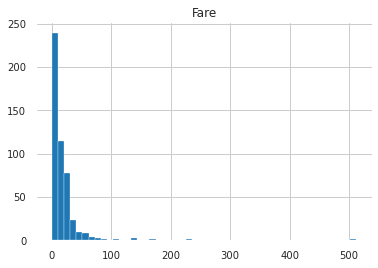

In [107]:
# Based on the values of S (missing) compared to the distribution, should predict which are in cabins as well
df_train_split[['Cabin_aug','Fare']][df_train_split['Cabin_aug'].str.contains("S")].hist(bins=50) 


In [110]:
df_train_split['Cabin_aug'] = df_train_split['Cabin_aug'].apply(lambda x: None if x == 'S' else x) #setting to Nan
df_train_split.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Cabin_aug
387,388,2,"Buss, Miss. Kate",female,36,0,0,27849,13.0000,S,S,1,None
531,532,3,"Toufik, Mr. Nakli",male,S,0,0,2641,7.2292,S,C,0,None
480,481,3,"Goodwin, Master. Harold Victor",male,9,5,2,CA 2144,46.9000,S,S,0,None
217,218,2,"Jacobsohn, Mr. Sidney Samuel",male,42,1,0,243847,27.0000,S,S,0,None
799,800,3,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",female,30,1,1,345773,24.1500,S,S,0,None


In [113]:
# # in progress 
# from sklearn.impute import KNNImputer # applying https://chrisalbon.com/machine_learning/preprocessing_structured_data/imputing_missing_class_labels_using_k-nearest_neighbors/

# imputer = KNNImputer(n_neighbors= 3)
# df_filled = imputer.fit_transform(df_train_split[['Cabin_aug','Fare']])
# df_filled

# Potential Next Steps / Changes to Considuer
- Potentially use K-Fold Cross validation due to small size 
- https://alexforrest.github.io/you-might-be-leaking-data-even-if-you-cross-validate.html
- https://machinelearningmastery.com/data-preparation-without-data-leakage/